## Monte Carlo Simulation for Option Pricing

Purpose: To estimate the price of European and Asian call options using the Monte Carlo simulation technique. This method simulates numerous paths for the underlying asset's price, then calculates the option's payoff for each path to find the average payoff, which is discounted back to present value.
Key Parameters:

S: Initial stock price

K: Strike price of the option

T: Time to maturity (in years)

r: Risk-free interest rate
'
sigma: Volatility of the underlying asset

num_simulations: Number of simulated paths

num_steps: Number of discrete time steps in each simulation

Variance Reduction Techniques: Implements antithetic variates and control variates to reduce the variance of the Monte Carlo estimate, thus improving accuracy with fewer simulations.

The Call Option Price is: 10.35991425560517


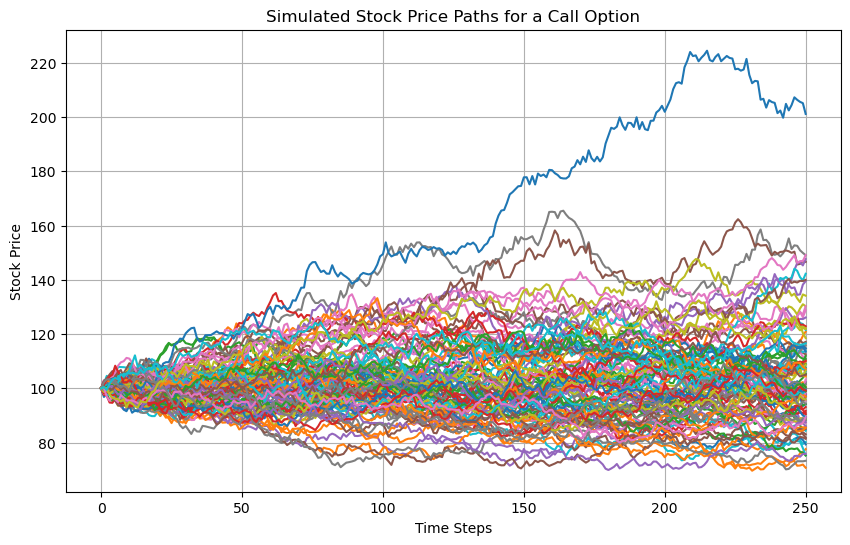

In [74]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)  # Set the seed for reproducibility

def monte_carlo_paths(S, K, T, r, sigma, option_type='call', num_simulations=10000, num_steps=250,
                      use_antithetic_variates=False, use_control_variate=False):
    dt = T / num_steps  # Time step
    price_paths = np.zeros((num_steps + 1, num_simulations))
    price_paths[0] = S  # Initial price is the current stock price
    
    for i in range(1, num_steps + 1):
        if use_antithetic_variates:
            # Generate random numbers for half of the paths
            Z = np.random.standard_normal(num_simulations // 2)
            # Update the first half of the price paths
            price_paths[i, :num_simulations // 2] = price_paths[i - 1, :num_simulations // 2] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
            # Update the second half of the price paths using antithetic variates
            price_paths[i, num_simulations // 2:] = price_paths[i - 1, num_simulations // 2:] * np.exp((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt) * Z)
        else:
            # Generate random numbers for all paths
            Z = np.random.standard_normal(num_simulations)
            # Update all price paths
            price_paths[i] = price_paths[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # Calculating the option price based on the final stock prices
    final_prices = price_paths[-1]
    
    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    else:
        payoffs = np.maximum(K - final_prices, 0)
    
    if use_control_variate:
        # Adjust payoffs using the control variate
        control_variate = np.mean(final_prices) - S * np.exp(r * T)
        payoffs -= control_variate
    
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price, price_paths

# Parameters
S = 100  # Underlying asset price
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
num_simulations = 10000
num_steps = 250  # Number of time steps

option_price, price_paths = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps)
print(f"The Call Option Price is: {option_price}")

# Plotting the simulated stock price paths
plt.figure(figsize=(10, 6))
plt.plot(price_paths[:, :100])  # Plot only the first 100 paths for clarity
plt.title(f'Simulated Stock Price Paths for a Call Option')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()


## Crank-Nicolson Finite Difference Method for Option Pricing

Purpose: To price European options using the Crank-Nicolson finite difference method, which is a numerical method for solving partial differential equations (PDEs) associated with option pricing models.
Key Features:

M, N: Number of time and space steps used in discretizing the option pricing PDE.

Utilizes a tridiagonal matrix solver to efficiently handle the linear system of equations arising in the discretization process.

In [75]:
import numpy as np
import scipy.linalg as linalg

def crank_nicolson_european_option(S, K, T, r, sigma, M, N, option_type='call'):
    """
    Price a European option (call or put) using the Crank-Nicolson finite difference method.
    
    Parameters:
    S (float)        : Initial stock price
    K (float)        : Strike price
    T (float)        : Time to expiration (in years)
    r (float)        : Risk-free interest rate (annual)
    sigma (float)    : Volatility of the underlying asset (annual)
    M (int)          : Number of time steps
    N (int)          : Number of space steps
    option_type (str): Type of the option ('call' or 'put')
    
    Returns:
    float: Price of the European option
    """

    # Setup the grid in space and time
    S_max = 2 * S
    dt = T / M
    dS = S_max / N
    i_values = np.arange(1, N)
    
    # Initialize the stock and option values
    stock_values = np.linspace(0, S_max, N + 1)
    if option_type == 'call':
        option_values = np.maximum(stock_values - K, 0)
    elif option_type == 'put':
        option_values = np.maximum(K - stock_values, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Setup the coefficients matrix
    alpha = 0.25 * dt * ((sigma**2) * (i_values**2) - r * i_values)
    beta = -dt * 0.5 * ((sigma**2) * (i_values**2) + r)
    gamma = 0.25 * dt * ((sigma**2) * (i_values**2) + r * i_values)
    
    # Create the M matrix
    M1 = -np.diag(alpha[1:], -1) + np.diag(1 - beta) - np.diag(gamma[:-1], 1)
    M2 = np.diag(alpha[1:], -1) + np.diag(1 + beta) + np.diag(gamma[:-1], 1)
    
    # Solve the system of equations at each time step
    P, L, U = linalg.lu(M1)
    
    for t in range(M - 1, -1, -1):
        option_values[1:N] = linalg.solve(L, np.dot(M2, option_values[1:N]))
        option_values[1:N] = linalg.solve(U, option_values[1:N])
        
        # Set the boundary conditions based on the option type
        if option_type == 'call':
            option_values[0] = 0
            option_values[N] = S_max - K * np.exp(-r * dt * (M - t))
        elif option_type == 'put':
            option_values[0] = K * np.exp(-r * dt * (M - t))
            option_values[N] = 0
        
    return option_values[N//2]  # Return the option price at S

# Test the function with example parameters
S = 100  # Underlying asset price
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
M = 1000      # Number of time steps
N = 100       # Number of space steps

call_price = crank_nicolson_european_option(S, K, T, r, sigma, M, N, 'call')
print(f"The European Call Option Price is: {call_price}")


The European Call Option Price is: 10.353691483698979


## Black-Scholes Model for Option Pricing and Greeks

Purpose: Provides an analytical solution for pricing European call and put options and calculates the Greeks (Delta, Gamma, Vega) using the Black-Scholes formula.
Key Greeks Calculated:

Delta: Sensitivity of option price to changes in the underlying asset's price.

Gamma: Rate of change of Delta with respect to changes in the underlying asset's price.

Vega: Sensitivity of option price to changes in the volatility of the underlying asset.

In [76]:
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Black-Scholes formula to calculate European option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
    return option_price


# Compute prices
#analytical_price = black_scholes(S, K, T, r, sigma, 'call')

In [77]:
import numpy as np
from scipy.stats import norm
import scipy.linalg as linalg
import matplotlib.pyplot as plt

# Parameters (common for all methods)
S = 100  # Underlying asset price
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility

# Monte Carlo Simulation
np.random.seed(0)  # Set seed for reproducibility
num_simulations = 10000
num_steps = 250
monte_carlo_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps)

# Crank-Nicolson Finite Difference Method
M = 1000      # Number of time steps
N = 100       # Number of space steps
crank_nicolson_price = crank_nicolson_european_option(S, K, T, r, sigma, M, N,'call')

# Black-Scholes Model
black_scholes_price = black_scholes(S, K, T, r, sigma, 'call')

# Compare results
print(f"Monte Carlo Simulation Price: {monte_carlo_price}")
print(f"Crank-Nicolson Finite Difference Price: {crank_nicolson_price}")
print(f"Black-Scholes Analytical Price: {black_scholes_price}")


Monte Carlo Simulation Price: 10.35991425560517
Crank-Nicolson Finite Difference Price: 10.353691483698979
Black-Scholes Analytical Price: 10.450583572185565


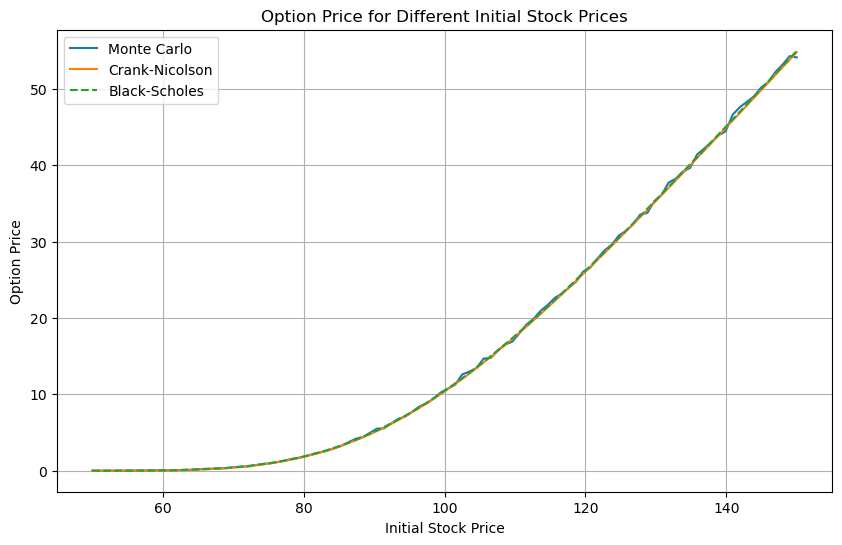

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.linalg as linalg

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility

# Range of initial stock prices
S_values = np.linspace(K/2, 1.5*K, 100)

# Arrays to store option prices
monte_carlo_prices = []
crank_nicolson_prices = []
black_scholes_prices = []

# Parameters for numerical methods
num_simulations = 10000
num_steps = 250
M = 1000  # Number of time steps for Crank-Nicolson
N = 100   # Number of space steps for Crank-Nicolson

# Calculate option prices for each initial stock price
for S in S_values:
    # Monte Carlo Simulation
    mc_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps)
    monte_carlo_prices.append(mc_price)
    
    # Crank-Nicolson Finite Difference Method
    cn_price = crank_nicolson_european_option(S, K, T, r, sigma, M, N,'call')
    crank_nicolson_prices.append(cn_price)
    
    # Black-Scholes Model
    bs_price = black_scholes(S, K, T, r, sigma, 'call')
    black_scholes_prices.append(bs_price)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(S_values, monte_carlo_prices, label='Monte Carlo')
plt.plot(S_values, crank_nicolson_prices, label='Crank-Nicolson')
plt.plot(S_values, black_scholes_prices, label='Black-Scholes', linestyle='--')
plt.title('Option Price for Different Initial Stock Prices')
plt.xlabel('Initial Stock Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()


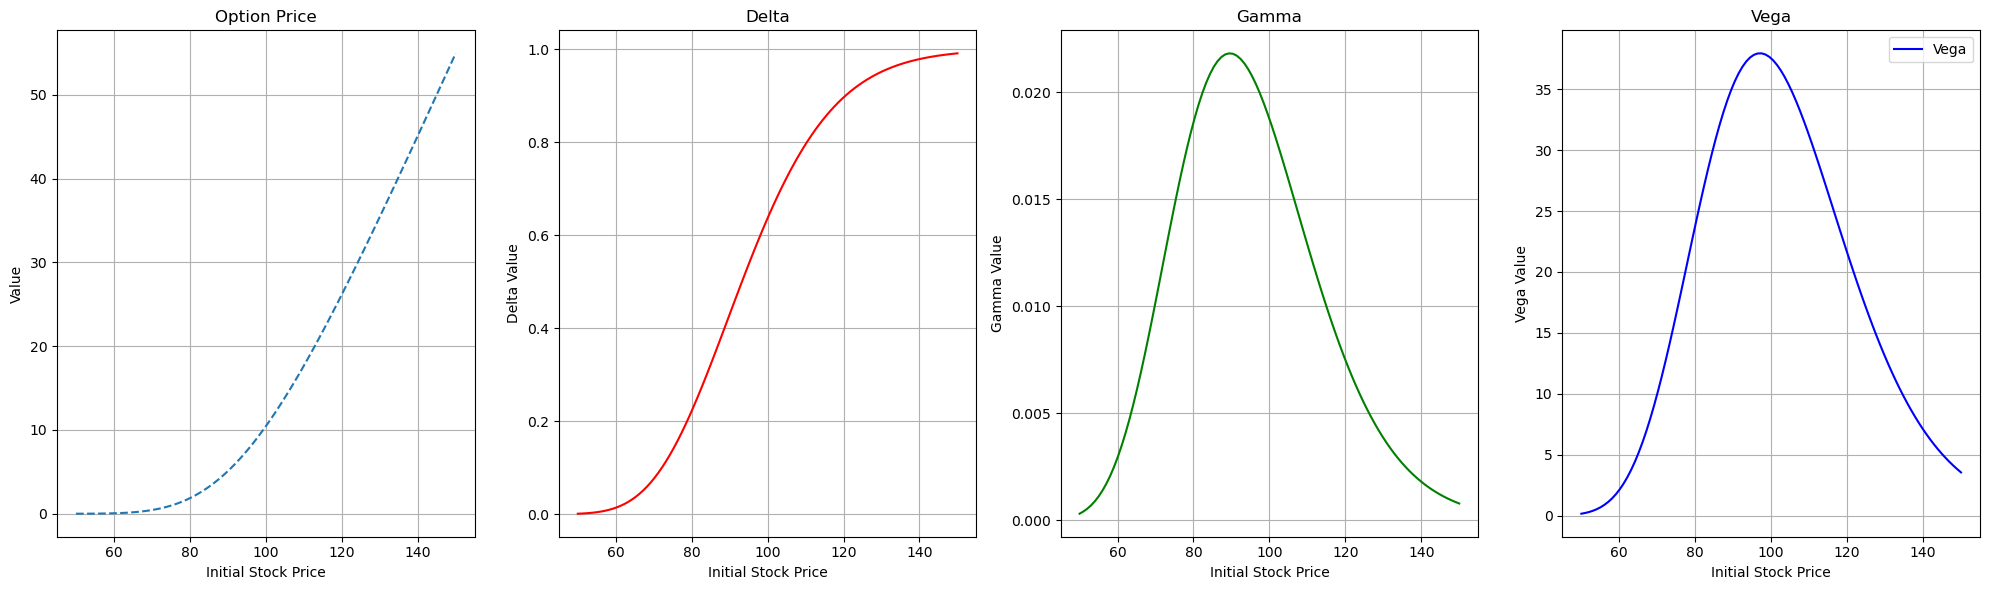

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility

# Function definition for Black-Scholes price, delta, gamma, and vega
def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    """Black-Scholes formula to calculate European option price, delta, gamma, and vega."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    
    # Gamma (same for call and put)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    
    # Vega (same for call and put, not divided by 100)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    
    return option_price, delta, gamma, vega

# Range of initial stock prices
S_values = np.linspace(K/2, 1.5*K, 100)

# Arrays to store option prices, deltas, gammas, and vegas
black_scholes_prices = []
deltas = []
gammas = []
vegas = []

# Calculate option prices, deltas, gammas, and vegas for each initial stock price
for S in S_values:
    # Black-Scholes Model
    bs_price, delta, gamma, vega = black_scholes_greeks(S, K, T, r, sigma, 'call')
    black_scholes_prices.append(bs_price)
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega)

# Plotting the results
plt.figure(figsize=(20, 6))  # Adjusted figure size for better visibility

# Plotting Black-Scholes Price
plt.subplot(1, 4, 1)
plt.plot(S_values, black_scholes_prices, label='Black-Scholes Price', linestyle='--')
plt.title('Option Price')
plt.xlabel('Initial Stock Price')
plt.ylabel('Value')
plt.grid(True)

# Plotting Delta
plt.subplot(1, 4, 2)
plt.plot(S_values, deltas, label='Delta', color='red')
plt.title('Delta')
plt.xlabel('Initial Stock Price')
plt.ylabel('Delta Value')
plt.grid(True)

# Plotting Gamma
plt.subplot(1, 4, 3)
plt.plot(S_values, gammas, label='Gamma', color='green')
plt.title('Gamma')
plt.xlabel('Initial Stock Price')
plt.ylabel('Gamma Value')
plt.grid(True)

# Plotting Vega
plt.subplot(1, 4, 4)
plt.plot(S_values, vegas, label='Vega', color='blue')
plt.title('Vega')
plt.xlabel('Initial Stock Price')
plt.ylabel('Vega Value')
plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()


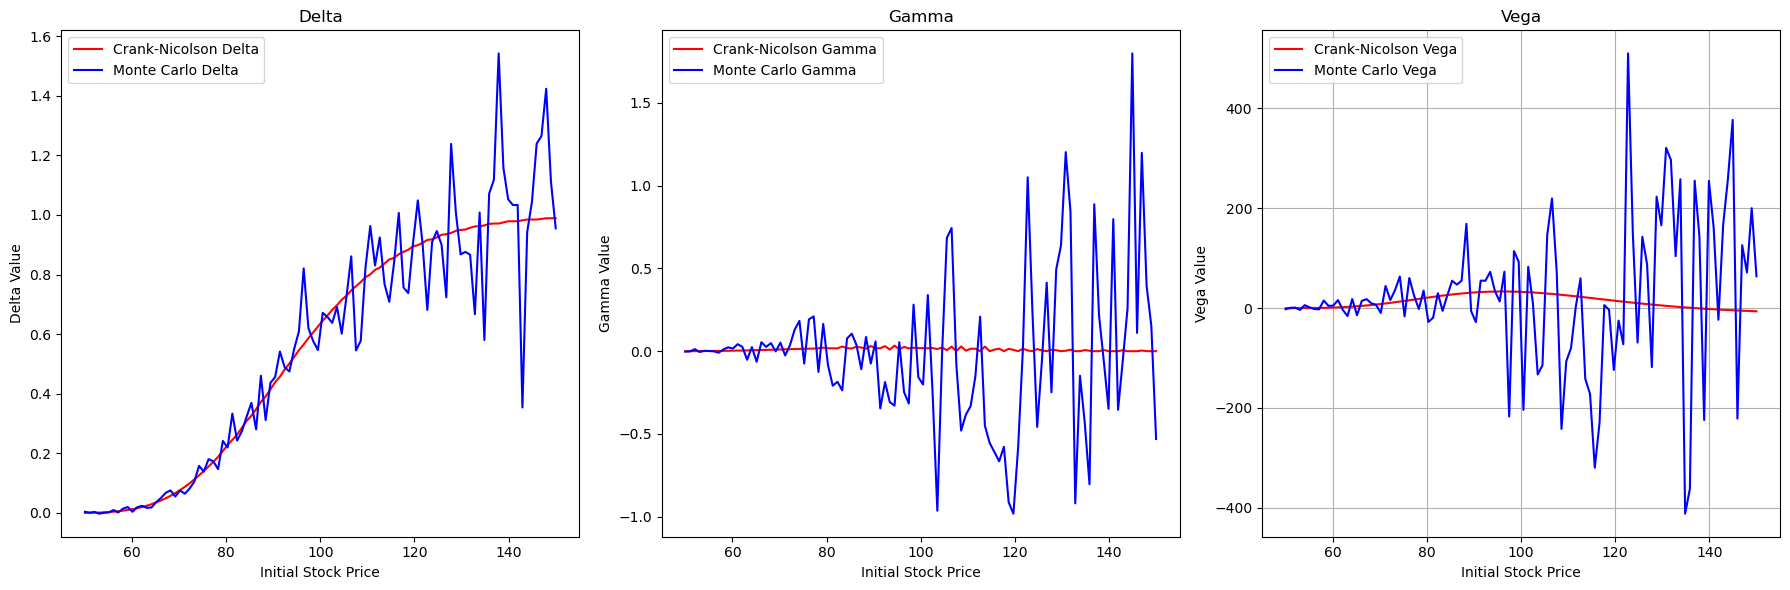

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.linalg as linalg

# ... (other code, including function definitions for monte_carlo_paths, crank_nicolson_european_call, black_scholes)

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
S_values = np.linspace(K/2, 1.5*K, 100)  # Range of initial stock prices

# Define perturbations
dS = 1e-2 * K
dSigma = 1e-2 * sigma

# Arrays to store Greeks for Crank-Nicolson and Monte Carlo
cn_deltas = []
cn_gammas = []
cn_vegas = []

mc_deltas = []
mc_gammas = []
mc_vegas = []

# Parameters for numerical methods
num_simulations = 10000
num_steps = 250
M = 1000  # Number of time steps for Crank-Nicolson
N = 100   # Number of space steps for Crank-Nicolson

for S in S_values:
# Crank-Nicolson Finite Difference Method
    price = crank_nicolson_european_option(S, K, T, r, sigma, M, N)
    price_plus_dS = crank_nicolson_european_option(S + dS, K, T, r, sigma, M, N)
    price_minus_dS = crank_nicolson_european_option(S - dS, K, T, r, sigma, M, N)
    price_plus_dSigma = crank_nicolson_european_option(S, K, T, r, sigma + dSigma, M, N)
    
    cn_delta = (price_plus_dS - price_minus_dS) / (2 * dS)
    cn_gamma = (price_plus_dS - 2 * price + price_minus_dS) / (dS ** 2)
    cn_vega = (price_plus_dSigma - price) / dSigma  # Note: Vega is per 1% change in volatility
    
    cn_deltas.append(cn_delta)
    cn_gammas.append(cn_gamma)
    cn_vegas.append(cn_vega)

    # Monte Carlo Simulation
    mc_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_plus_dS, _ = monte_carlo_paths(S + dS, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_minus_dS, _ = monte_carlo_paths(S - dS, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_plus_dSigma, _ = monte_carlo_paths(S, K, T, r, sigma + dSigma, 'call', num_simulations, num_steps)
    
    mc_delta = (mc_price_plus_dS - mc_price_minus_dS) / (2 * dS)
    mc_gamma = (mc_price_plus_dS - 2 * mc_price + mc_price_minus_dS) / (dS ** 2)
    mc_vega = (mc_price_plus_dSigma - mc_price) / dSigma  # Note: Vega is per 1% change in volatility
    
    mc_deltas.append(mc_delta)
    mc_gammas.append(mc_gamma)
    mc_vegas.append(mc_vega)

# Plotting the results
plt.figure(figsize=(18, 6))

# Plotting Delta
plt.subplot(1, 3, 1)
plt.plot(S_values, cn_deltas, label='Crank-Nicolson Delta', color='red')
plt.plot(S_values, mc_deltas, label='Monte Carlo Delta', color='blue')
plt.title('Delta')
plt.xlabel('Initial Stock Price')
plt.ylabel('Delta Value')
plt.legend()

# Plotting Gamma
plt.subplot(1, 3, 2)
plt.plot(S_values, cn_gammas, label='Crank-Nicolson Gamma', color='red')
plt.plot(S_values, mc_gammas, label='Monte Carlo Gamma', color='blue')
plt.title('Gamma')
plt.xlabel('Initial Stock Price')
plt.ylabel('Gamma Value')
plt.legend()

# Plotting Vega
plt.subplot(1, 3, 3)
plt.plot(S_values, cn_vegas, label='Crank-Nicolson Vega', color='red')
plt.plot(S_values, mc_vegas, label='Monte Carlo Vega', color='blue')
plt.title('Vega')
plt.xlabel('Initial Stock Price')
plt.ylabel('Vega Value')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()


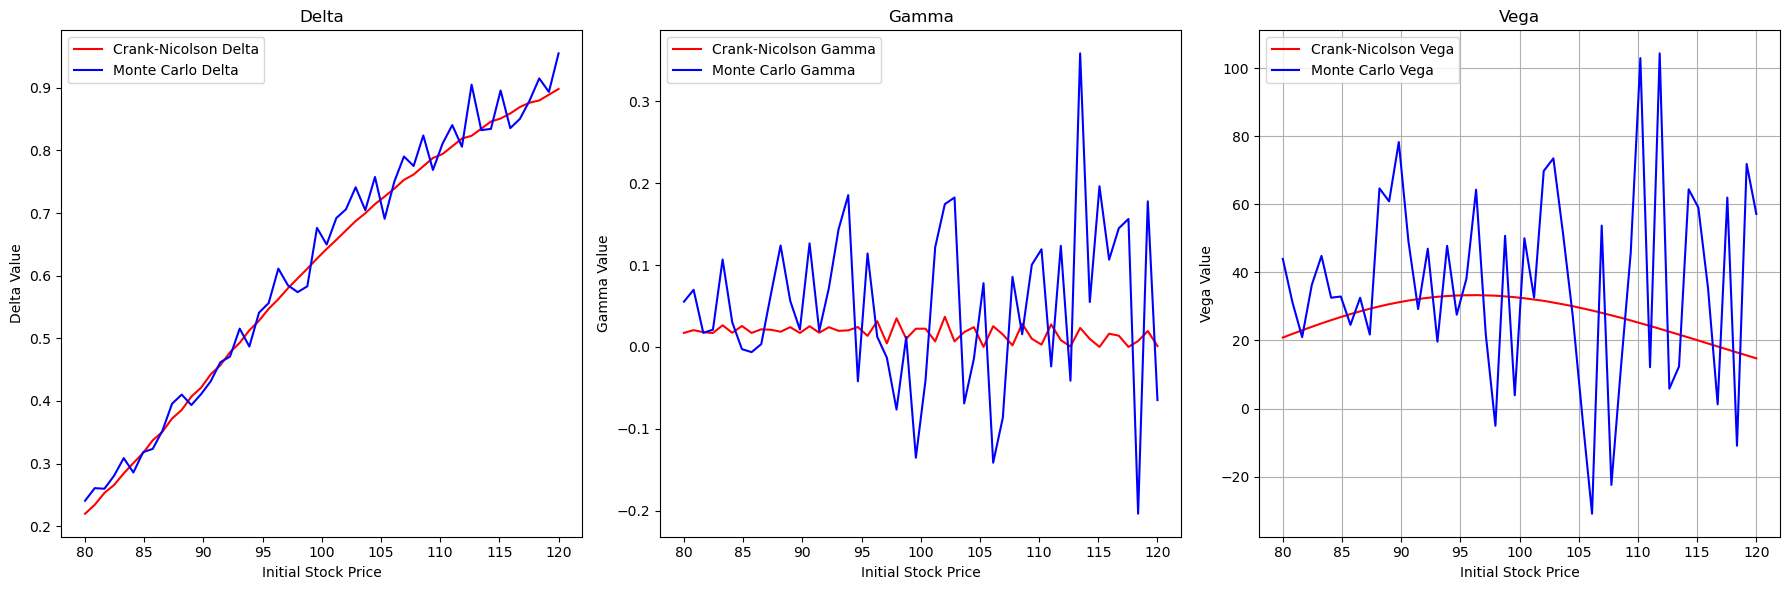

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.linalg as linalg

# Now repeat this experiment to attempt to reduce the noise of the Monte Carlo approach, this will be achieved by reducing the scope of the stock values, but increasing the number of Monte Carlo simulations

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
S_values = np.linspace(K-20, K+20, 50)  # Range of initial stock prices

# Define perturbations
dS = 1e-2 * K
dSigma = 1e-2 * sigma

# Arrays to store Greeks for Crank-Nicolson and Monte Carlo
cn_deltas = []
cn_gammas = []
cn_vegas = []

mc_deltas = []
mc_gammas = []
mc_vegas = []

# Parameters for numerical methods
num_simulations = 100000
num_steps = 250
M = 1000  # Number of time steps for Crank-Nicolson
N = 100   # Number of space steps for Crank-Nicolson

for S in S_values:
# Crank-Nicolson Finite Difference Method
    price = crank_nicolson_european_option(S, K, T, r, sigma, M, N)
    price_plus_dS = crank_nicolson_european_option(S + dS, K, T, r, sigma, M, N)
    price_minus_dS = crank_nicolson_european_option(S - dS, K, T, r, sigma, M, N)
    price_plus_dSigma = crank_nicolson_european_option(S, K, T, r, sigma + dSigma, M, N)
    
    cn_delta = (price_plus_dS - price_minus_dS) / (2 * dS)
    cn_gamma = (price_plus_dS - 2 * price + price_minus_dS) / (dS ** 2)
    cn_vega = (price_plus_dSigma - price) / dSigma  # Note: Vega is per 1% change in volatility
    
    cn_deltas.append(cn_delta)
    cn_gammas.append(cn_gamma)
    cn_vegas.append(cn_vega)

    # Monte Carlo Simulation
    mc_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_plus_dS, _ = monte_carlo_paths(S + dS, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_minus_dS, _ = monte_carlo_paths(S - dS, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_plus_dSigma, _ = monte_carlo_paths(S, K, T, r, sigma + dSigma, 'call', num_simulations, num_steps)
    
    mc_delta = (mc_price_plus_dS - mc_price_minus_dS) / (2 * dS)
    mc_gamma = (mc_price_plus_dS - 2 * mc_price + mc_price_minus_dS) / (dS ** 2)
    mc_vega = (mc_price_plus_dSigma - mc_price) / dSigma  # Note: Vega is per 1% change in volatility
    
    mc_deltas.append(mc_delta)
    mc_gammas.append(mc_gamma)
    mc_vegas.append(mc_vega)

# Plotting the results
plt.figure(figsize=(18, 6))

# Plotting Delta
plt.subplot(1, 3, 1)
plt.plot(S_values, cn_deltas, label='Crank-Nicolson Delta', color='red')
plt.plot(S_values, mc_deltas, label='Monte Carlo Delta', color='blue')
plt.title('Delta')
plt.xlabel('Initial Stock Price')
plt.ylabel('Delta Value')
plt.legend()

# Plotting Gamma
plt.subplot(1, 3, 2)
plt.plot(S_values, cn_gammas, label='Crank-Nicolson Gamma', color='red')
plt.plot(S_values, mc_gammas, label='Monte Carlo Gamma', color='blue')
plt.title('Gamma')
plt.xlabel('Initial Stock Price')
plt.ylabel('Gamma Value')
plt.legend()

# Plotting Vega
plt.subplot(1, 3, 3)
plt.plot(S_values, cn_vegas, label='Crank-Nicolson Vega', color='red')
plt.plot(S_values, mc_vegas, label='Monte Carlo Vega', color='blue')
plt.title('Vega')
plt.xlabel('Initial Stock Price')
plt.ylabel('Vega Value')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()


In [83]:
## Comparing the Monte Carlo variance reduction techniques.


import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)  # Set the seed for reproducibility

# Parameters
S = 100  # Underlying asset price
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
num_simulations = 10000
num_steps = 250  # Number of time steps


# Calculate the Black-Scholes analytical solution
analytical_price = black_scholes(S, K, T, r, sigma, 'call')
print(f"Analytical Black-Scholes Call Option Price: {analytical_price}")

# Test the function without variance reduction techniques
option_price, price_paths = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps)
print(f"The Call Option Price (without Variance Reduction) is: {option_price}")

# Test the function with Antithetic Variates
option_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps, use_antithetic_variates=True)
print(f"The Call Option Price (with Antithetic Variates) is: {option_price}")

# Test the function with Control Variate
option_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps, use_control_variate=True)
print(f"The Call Option Price (with Control Variate) is: {option_price}")

# Test the function with both variance reduction techniques
option_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps, use_antithetic_variates=True, use_control_variate=True)
print(f"The Call Option Price (with both Variance Reduction Techniques) is: {option_price}")


Analytical Black-Scholes Call Option Price: 10.450583572185565
The Call Option Price (without Variance Reduction) is: 10.35991425560517
The Call Option Price (with Antithetic Variates) is: 10.533545059591699
The Call Option Price (with Control Variate) is: 10.450096267342529
The Call Option Price (with both Variance Reduction Techniques) is: 10.423830871857811


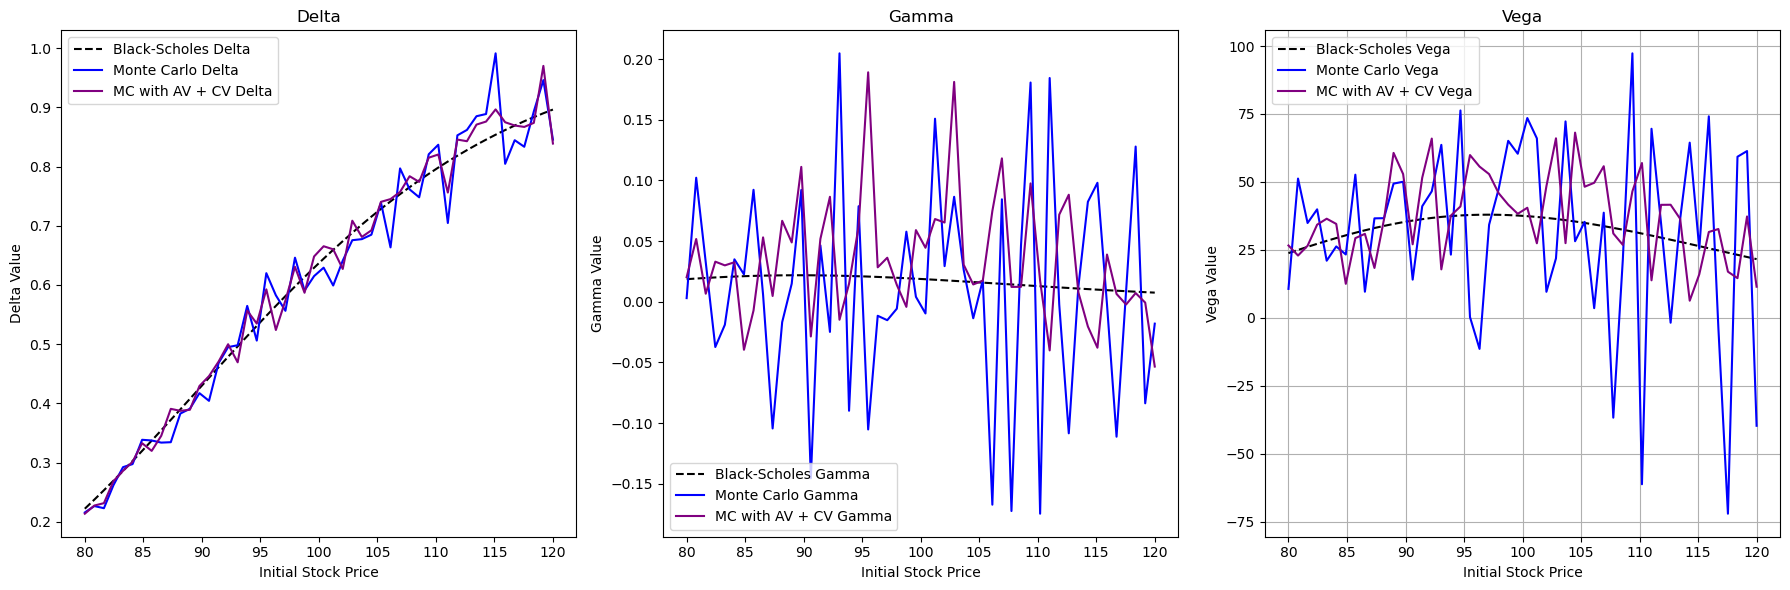

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.linalg as linalg

# ... (previous code for function definitions, including monte_carlo_paths)

# Parameters
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
S_values = np.linspace(K-20, K+20, 50)  # Range of initial stock prices

# Define perturbations
dS = 1e-2 * K
dSigma = 1e-2 * sigma

# Arrays to store Greeks for analytical Black-Scholes
bs_deltas = []
bs_gammas = []
bs_vegas = []

# Arrays to store Greeks for Monte Carlo with and without variance reduction
mc_deltas = []
mc_gammas = []
mc_vegas = []

mc_avcv_deltas = []  # Antithetic Variates + Control Variates
mc_avcv_gammas = []
mc_avcv_vegas = []

# Parameters for numerical methods
num_simulations = 100000
num_steps = 250

for S in S_values:
    # Analytical Black-Scholes Greeks
    bs_price, bs_delta, bs_gamma, bs_vega = black_scholes_greeks(S, K, T, r, sigma, 'call')
    bs_deltas.append(bs_delta)
    bs_gammas.append(bs_gamma)
    bs_vegas.append(bs_vega)
    
    # Monte Carlo Simulation without variance reduction
    mc_price, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_plus_dS, _ = monte_carlo_paths(S + dS, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_minus_dS, _ = monte_carlo_paths(S - dS, K, T, r, sigma, 'call', num_simulations, num_steps)
    mc_price_plus_dSigma, _ = monte_carlo_paths(S, K, T, r, sigma + dSigma, 'call', num_simulations, num_steps)
    
    mc_delta = (mc_price_plus_dS - mc_price_minus_dS) / (2 * dS)
    mc_gamma = (mc_price_plus_dS - 2 * mc_price + mc_price_minus_dS) / (dS ** 2)
    mc_vega = (mc_price_plus_dSigma - mc_price) / dSigma  # Note: Vega is per 1% change in volatility
    
    mc_deltas.append(mc_delta)
    mc_gammas.append(mc_gamma)
    mc_vegas.append(mc_vega)
    

    # Monte Carlo Simulation with both Antithetic Variates and Control Variates
    mc_price_avcv, _ = monte_carlo_paths(S, K, T, r, sigma, 'call', num_simulations, num_steps, use_antithetic_variates=True, use_control_variate=True)
    mc_price_plus_dS_avcv, _ = monte_carlo_paths(S + dS, K, T, r, sigma, 'call', num_simulations, num_steps, use_antithetic_variates=True, use_control_variate=True)
    mc_price_minus_dS_avcv, _ = monte_carlo_paths(S - dS, K, T, r, sigma, 'call', num_simulations, num_steps, use_antithetic_variates=True, use_control_variate=True)
    mc_price_plus_dSigma_avcv, _ = monte_carlo_paths(S, K, T, r, sigma + dSigma, 'call', num_simulations, num_steps, use_antithetic_variates=True, use_control_variate=True)
    
    mc_avcv_delta = (mc_price_plus_dS_avcv - mc_price_minus_dS) / (2 * dS)
    mc_avcv_gamma = (mc_price_plus_dS_avcv - 2 * mc_price_avcv + mc_price_minus_dS_avcv) / (dS ** 2)
    mc_avcv_vega = (mc_price_plus_dSigma_avcv - mc_price_avcv) / dSigma  # Note: Vega is per 1% change in volatility
    
    mc_avcv_deltas.append(mc_avcv_delta)
    mc_avcv_gammas.append(mc_avcv_gamma)
    mc_avcv_vegas.append(mc_avcv_vega)


# Plotting the results
plt.figure(figsize=(18, 6))

# Plotting Delta
plt.subplot(1, 3, 1)
plt.plot(S_values, bs_deltas, label='Black-Scholes Delta', color='black', linestyle='dashed')
plt.plot(S_values, mc_deltas, label='Monte Carlo Delta', color='blue')
plt.plot(S_values, mc_avcv_deltas, label='MC with AV + CV Delta', color='purple')
plt.title('Delta')
plt.xlabel('Initial Stock Price')
plt.ylabel('Delta Value')
plt.legend()

# Plotting Gamma
plt.subplot(1, 3, 2)
plt.plot(S_values, bs_gammas, label='Black-Scholes Gamma', color='black', linestyle='dashed')
plt.plot(S_values, mc_gammas, label='Monte Carlo Gamma', color='blue')
plt.plot(S_values, mc_avcv_gammas, label='MC with AV + CV Gamma', color='purple')
plt.title('Gamma')
plt.xlabel('Initial Stock Price')
plt.ylabel('Gamma Value')
plt.legend()

# Plotting Vega
plt.subplot(1, 3, 3)
plt.plot(S_values, bs_vegas, label='Black-Scholes Vega', color='black', linestyle='dashed')
plt.plot(S_values, mc_vegas, label='Monte Carlo Vega', color='blue')
plt.plot(S_values, mc_avcv_vegas, label='MC with AV + CV Vega', color='purple')
plt.title('Vega')
plt.xlabel('Initial Stock Price')
plt.ylabel('Vega Value')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()


In [126]:
## Lets now come up with some code to evaluate the greeks for each of the methods.

# Function definition for Black-Scholes price, delta, gamma, and vega   (THIS HAS BEEN COPIED FROM ABOVE)
def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    """Black-Scholes formula to calculate European option price, delta, gamma, and vega."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    
    # Gamma (same for call and put)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    
    # Vega (same for call and put, not divided by 100)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    
    return option_price, delta, gamma, vega

def monte_carlo_greeks(S, K, T, r, sigma, option_type='call', num_simulations=20000, num_steps=250):
    dS = S * 0.01  # 1% change in stock price
    dSigma = sigma * 0.01  # 1% change in volatility

    # Price for S, S+dS, and S-dS
    price, _ = monte_carlo_paths(S, K, T, r, sigma, option_type, num_simulations, num_steps)
    price_dS_up, _ = monte_carlo_paths(S + dS, K, T, r, sigma, option_type, num_simulations, num_steps)
    price_dS_down, _ = monte_carlo_paths(S - dS, K, T, r, sigma, option_type, num_simulations, num_steps)

    # Price for sigma and sigma + dSigma
    price_dSigma_up, _ = monte_carlo_paths(S, K, T, r, sigma + dSigma, option_type, num_simulations, num_steps)

    # Calculate Delta
    delta = (price_dS_up - price_dS_down) / (2 * dS)

    # Calculate Gamma
    gamma = (price_dS_up - 2 * price + price_dS_down) / (dS ** 2)

    # Calculate Vega (per 1% change in volatility)
    vega = (price_dSigma_up - price) / dSigma

    return delta, gamma, vega


def finite_difference_greeks(S, K, T, r, sigma, option_type = 'call'):
    # Set small changes for S and sigma
    M = 500
    N = 500
    delta_S = S * 0.01  # 1% of the stock price
    delta_sigma = sigma * 0.01  # 1% of the volatility

    # Price the option for different S and sigma
    option_price = crank_nicolson_european_option(S, K, T, r, sigma, M, N, option_type)
    option_price_plus_S = crank_nicolson_european_option(S + delta_S, K, T, r, sigma, M, N, option_type)
    option_price_minus_S = crank_nicolson_european_option(S - delta_S, K, T, r, sigma, M, N, option_type)
    option_price_plus_sigma = crank_nicolson_european_option(S, K, T, r, sigma + delta_sigma, M, N, option_type)
    option_price_minus_sigma = crank_nicolson_european_option(S, K, T, r, sigma - delta_sigma, M, N, option_type)

    # Calculate delta
    fd_delta = (option_price_plus_S - option_price_minus_S) / (2 * delta_S)

    # Calculate gamma
    fd_gamma = (option_price_plus_S - 2 * option_price + option_price_minus_S) / (delta_S ** 2)

    # Calculate vega
    fd_vega = (option_price_plus_sigma - option_price_minus_sigma) / (2 * delta_sigma)

    return fd_delta, fd_gamma, fd_vega




#Example

# Parameters
S = 100  # Underlying asset price
K = 100  # Strike price
T = 1    # Time to maturity in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility


# Calculate Greeks using Black-Scholes
bs_price, bs_delta, bs_gamma, bs_vega = black_scholes_greeks(S, K, T, r, sigma, 'call')

# Calculate Greeks using Monte Carlo
mc_delta, mc_gamma, mc_vega = monte_carlo_greeks(S, K, T, r, sigma, 'call')

# Calculate Greeks using Finite Difference
fd_delta, fd_gamma, fd_vega = finite_difference_greeks(S, K, T, r, sigma, 'call') 


# Compare the results
print(f"Black-Scholes: Delta={bs_delta}, Gamma={bs_gamma}, Vega={bs_vega}")
print(f"Monte Carlo: Delta={mc_delta}, Gamma={mc_gamma}, Vega={mc_vega}")
print(f"Finite Difference: Delta={fd_delta}, Gamma={fd_gamma}, Vega={fd_vega}")

Black-Scholes: Delta=0.6368306511756191, Gamma=0.018762017345846895, Vega=37.52403469169379
Monte Carlo: Delta=0.567480854952791, Gamma=-0.014220834961882645, Vega=53.2019565743056
Finite Difference: Delta=0.6350579977840507, Gamma=0.019509055513701412, Vega=32.76275388828864


## Greek Calculations for Hedging Strategies

Objective: Demonstrates how to calculate and adjust hedging positions dynamically to manage the risk associated with holding options. It involves calculating the Greeks for both the portfolio and potential hedging instruments, then solving a system of linear equations to find the required positions in hedging instruments that neutralize the portfolio's Greek exposures.
Key Concepts:

Dynamic hedging: Adjusting positions in hedging instruments over time as market conditions and the portfolio's Greek exposures change.

Monte Carlo and finite difference methods for Greek calculations: These methods provide numerical estimates for the Greeks, which can be used when analytical solutions are not feasible or when dealing with complex options like Asian options.

In [127]:
import numpy as np

# Assume black_scholes_greeks, monte_carlo_greeks, and finite_difference_greeks functions are defined here

# Example Portfolio
portfolio_options = [
    (100, 105, 30/365, 0.01, 0.2, 'call'),
    (100, 95, 30/365, 0.01, 0.2, 'put')
    # Add more options as needed
]

# Potential Hedging Instruments
hedging_instruments = [
    (100, 100, 60/365, 0.01, 0.25, 'call'),
    (100, 100, 60/365, 0.01, 0.25, 'put'),
    (100, 110, 60/365, 0.01, 0.25, 'call')
    # Add more instruments as needed
]

# Function to calculate and print the required positions for hedging
def calculate_and_print_hedging_requirements(calculate_greeks, method_name):
    portfolio_greeks = np.sum([calculate_greeks(*opt)[0:3] for opt in portfolio_options], axis=0)
    hedging_greeks = np.array([calculate_greeks(*inst)[0:3] for inst in hedging_instruments])
    amounts = np.linalg.solve(hedging_greeks, -portfolio_greeks)

    print(f"Method: {method_name}")
    for i, amount in enumerate(amounts, 1):
        print(f"Instrument {i}: {amount}")
    print()

# Calculate and print for each method
calculate_and_print_hedging_requirements(black_scholes_greeks, "Black-Scholes")
calculate_and_print_hedging_requirements(monte_carlo_greeks, "Monte Carlo")
calculate_and_print_hedging_requirements(finite_difference_greeks, "Finite Difference")


Method: Black-Scholes
Instrument 1: -0.3022603181890662
Instrument 2: -1.1282401478055388
Instrument 3: 15.958231750424199

Method: Monte Carlo
Instrument 1: -1.3355262078569812
Instrument 2: -37.003842997097266
Instrument 3: -0.13766405417812158

Method: Finite Difference
Instrument 1: 0.057611507225889494
Instrument 2: 39882.526541848594
Instrument 3: -100.84311658697352



## Monte Carlo Simulation for Asian Option Pricing

Purpose: Extends the Monte Carlo simulation method to price Asian options, which have payoffs dependent on the average price of the underlying asset over some portion of the life of the option.

Key Difference from European Option Pricing: Calculates the average of simulated price paths to determine the option's payoff, reflecting the unique payoff structure of Asian options.

The Asian Call Option Price is: 5.78636463191907


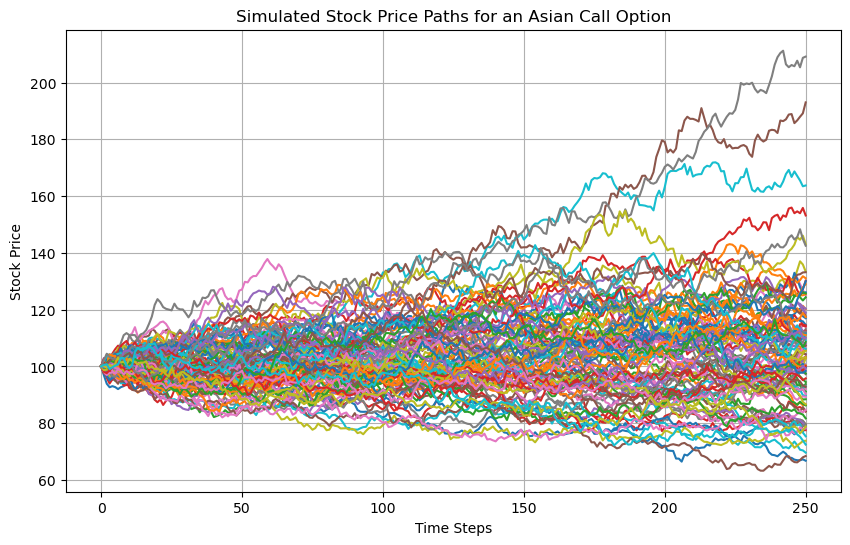

In [132]:
## Lets now complete an exotic option

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def monte_carlo_asian_paths(S, K, T, r, sigma, num_simulations=10000, num_steps=250):
    dt = T / num_steps
    price_paths = np.zeros((num_steps + 1, num_simulations))
    price_paths[0] = S

    for i in range(1, num_steps + 1):
        Z = np.random.standard_normal(num_simulations)
        price_paths[i] = price_paths[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Calculate the average price for each simulation
    average_price = np.mean(price_paths[1:], axis=0)

    # Asian call option payoff
    payoffs = np.maximum(average_price - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price, price_paths

# Asian option parameters
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
num_simulations = 100000
num_steps = 250

asian_option_price, price_paths = monte_carlo_asian_paths(S, K, T, r, sigma, num_simulations, num_steps)
print(f"The Asian Call Option Price is: {asian_option_price}")

plt.figure(figsize=(10, 6))
plt.plot(price_paths[:, :100])
plt.title('Simulated Stock Price Paths for an Asian Call Option')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

def monte_carlo_asian_greeks(S, K, T, r, sigma, num_simulations=20000, num_steps=250):
    dS = S * 0.01
    dSigma = sigma * 0.01

    price, _ = monte_carlo_asian_paths(S, K, T, r, sigma, num_simulations, num_steps)
    price_dS_up, _ = monte_carlo_asian_paths(S + dS, K, T, r, sigma, num_simulations, num_steps)
    price_dS_down, _ = monte_carlo_asian_paths(S - dS, K, T, r, sigma, num_simulations, num_steps)
    price_dSigma_up, _ = monte_carlo_asian_paths(S, K, T, r, sigma + dSigma, num_simulations, num_steps)

    delta = (price_dS_up - price_dS_down) / (2 * dS)
    gamma = (price_dS_up - 2 * price + price_dS_down) / (dS ** 2)
    vega = (price_dSigma_up - price) / dSigma

    return delta, gamma, vega


## Convergence Analysis and Variance Reduction Techniques

Objective: Analyzes the convergence behavior of the Monte Carlo simulation prices for an option as the number of simulations increases. It also demonstrates the effectiveness of variance reduction techniques (antithetic variates and control variates) in improving the accuracy of Monte Carlo estimates.

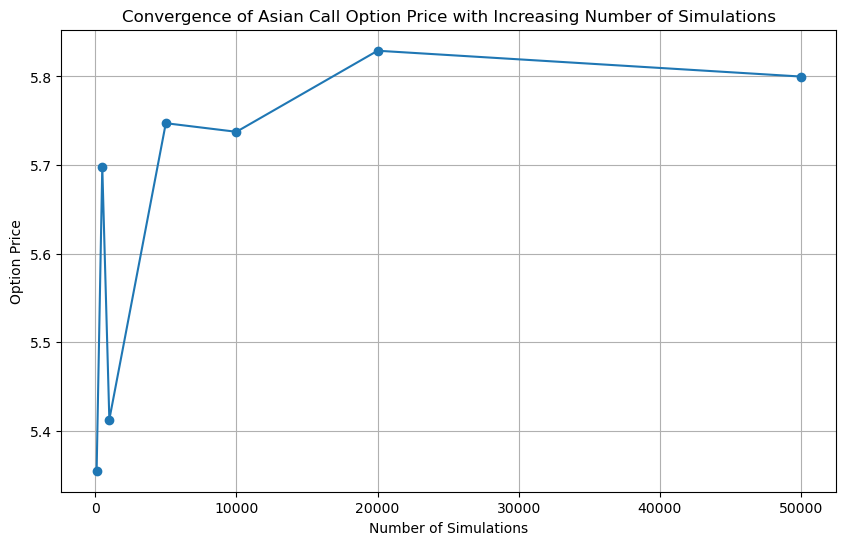

In [133]:
## We now do some convergence analysis.

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Define the function for Asian option pricing
def monte_carlo_asian_paths(S, K, T, r, sigma, num_simulations=10000, num_steps=250):
    dt = T / num_steps
    price_paths = np.zeros((num_steps + 1, num_simulations))
    price_paths[0] = S

    for i in range(1, num_steps + 1):
        Z = np.random.standard_normal(num_simulations)
        price_paths[i] = price_paths[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    average_price = np.mean(price_paths[1:], axis=0)
    payoffs = np.maximum(average_price - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

# Parameters for the Asian option
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
num_steps = 250

# Array of different numbers of simulations
num_simulations_array = [100, 500, 1000, 5000, 10000, 20000, 50000]
option_prices = []

# Run simulations and store results
for num_simulations in num_simulations_array:
    price = monte_carlo_asian_paths(S, K, T, r, sigma, num_simulations, num_steps)
    option_prices.append(price)

# Plotting the convergence of option prices
plt.figure(figsize=(10, 6))
plt.plot(num_simulations_array, option_prices, marker='o')
plt.title('Convergence of Asian Call Option Price with Increasing Number of Simulations')
plt.xlabel('Number of Simulations')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()


## Dynamic Hedging Simulation (Code currently doesn't work)

Purpose: Simulates a dynamic hedging strategy by recalculating and adjusting hedging positions as simulated market conditions change over time. It emphasizes the practical application of the theoretical concepts in managing the risks of an options portfolio in a dynamic market environment.

In [135]:
import numpy as np
import time

# Assume the previous functions are defined here.

# Function to simulate market conditions (you can refine this to be more sophisticated)
def simulate_market_conditions(S, sigma):
    # Simulate some market condition changes
    S += np.random.normal(0, 1)  # Random walk simulation
    sigma += np.random.normal(0, 0.01)  # Random change in volatility
    return S, sigma

# Function to perform dynamic hedging
def dynamic_hedging():
    # Initial conditions
    S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
    portfolio_options = [(S, K, T, r, sigma, 'call')]
    hedging_instruments = [(S, K, T, r, sigma, 'put')]

    while T > 0:
        # Simulate market conditions
        S, sigma = simulate_market_conditions(S, sigma)

        # Recalculate Greeks and Hedging Requirements
        portfolio_greeks = np.sum([black_scholes_greeks(*opt)[0:3] for opt in portfolio_options], axis=0)
        hedging_greeks = np.array([black_scholes_greeks(*inst)[0:3] for inst in hedging_instruments])
        
        try:
            amounts = np.linalg.solve(hedging_greeks, -portfolio_greeks)
        except np.linalg.LinAlgError:
            print("Hedging matrix is singular, cannot solve.")
            break

        # Implement Rebalancing Criteria and Risk Management Here

        # Logging the hedging action
        print(f"Market Conditions: S={S}, sigma={sigma}")
        print(f"Portfolio Greeks: {portfolio_greeks}")
        print("Hedging Amounts:", amounts)

        # Update Time to Maturity
        T -= 0.01  # Decrement time (this represents the passage of time, adjust as needed)
        time.sleep(1)  # Sleep for a while to simulate time (remove in real trading)

# Run the dynamic hedging simulation
dynamic_hedging()


Hedging matrix is singular, cannot solve.


In [2]:
## The following represents future iterations of this project

# Modeling Options Under Non-Normal Empirical Distributions

Overview

Financial markets exhibit characteristics that are often not adequately captured by the normal distribution assumptions underlying classical models like Black-Scholes. Empirical evidence shows that asset returns can have fat tails (higher kurtosis) and skewness, which normal distributions do not account for. To address these discrepancies, modeling options under non-normal empirical distributions becomes crucial. This approach involves using observed market data to model the underlying asset's return distribution more accurately.

Objectives

Capture Market Anomalies: Accurately represent the leptokurtic nature of market returns and the observed skewness in the distribution of asset prices.
Improve Pricing Accuracy: Enhance the precision of option pricing and risk assessment by using distributions that better reflect actual market behaviors.
Risk Management: Provide a more realistic assessment of tail risks and extreme market movements, enabling better risk management strategies.

Key Concepts

Empirical Distributions: Utilize historical return data to construct an empirical distribution of returns rather than assuming a normal distribution.
Fat Tails and Skewness: Incorporate models that account for the higher probability of extreme outcomes (fat tails) and asymmetry (skewness) in returns.
Parametric and Non-Parametric Methods: Explore both parametric methods (e.g., Generalized Extreme Value, Stable distributions) and non-parametric methods (e.g., kernel density estimation) for modeling empirical distributions.

Implementation Steps

Data Collection and Analysis: Gather historical price data for the underlying asset. Perform statistical analysis to understand its distributional characteristics, focusing on skewness, kurtosis, and potential autocorrelation in returns.
Model Selection: Choose appropriate models based on the empirical analysis. This could involve parametric models known to handle skew and kurtosis well or non-parametric models that make fewer assumptions about the data's distribution.
Parameter Estimation: Estimate the parameters for the chosen distribution models using techniques such as Maximum Likelihood Estimation (MLE), Method of Moments, or Bayesian methods.
Simulation and Pricing: Use the chosen empirical distribution to simulate paths of the underlying asset's price. Apply Monte Carlo simulation or other numerical methods to price options based on these simulated paths.
Validation and Calibration: Compare the empirical model's option pricing results with market prices to validate the model's effectiveness. Calibrate the model as necessary to improve accuracy.

Future Considerations

Model Complexity vs. Accuracy: Balancing the complexity of non-normal models with the computational efficiency and the added accuracy in option pricing.
Dynamic Adjustments: Incorporating methods to dynamically update the model as new data becomes available, ensuring the empirical distribution remains reflective of current market conditions.
Risk Metrics: Developing sophisticated risk metrics that leverage the non-normal nature of the empirical distribution to provide deeper insights into the options portfolio's risk profile.

The Call Option Price (non-Gaussian) is: 11.68817573692888


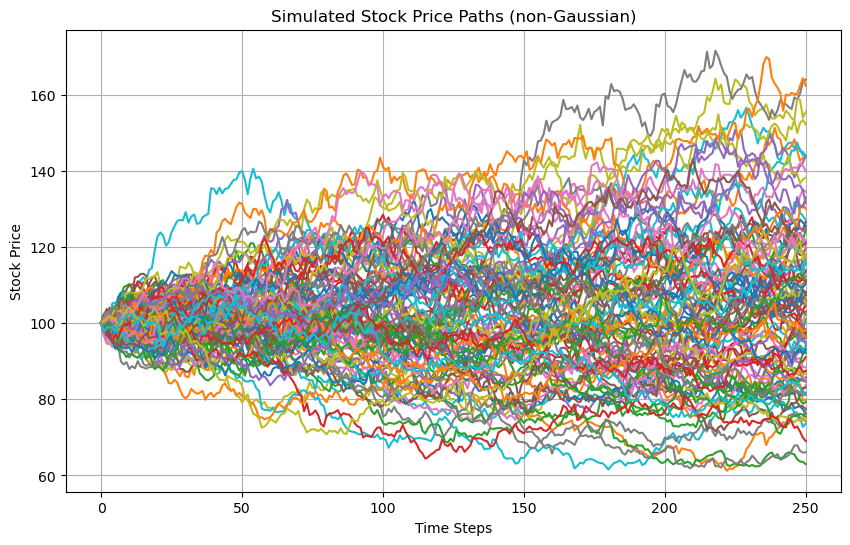

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

np.random.seed(0)  # For reproducibility

def monte_carlo_paths_non_gaussian(S, K, T, r, sigma, option_type='call', num_simulations=10000, num_steps=250, df=10):
    """
    Simulate Monte Carlo paths for an underlying asset using a non-Gaussian distribution (Student's t-distribution).

    Parameters:
    - S: Initial stock price
    - K: Strike price
    - T: Time to maturity (years)
    - r: Risk-free rate
    - sigma: Volatility of the underlying asset
    - option_type: 'call' or 'put'
    - num_simulations: Number of simulation paths
    - num_steps: Number of time steps
    - df: Degrees of freedom for the Student's t-distribution

    Returns:
    - option_price: Simulated option price
    - price_paths: Simulated paths of the underlying asset
    """
    dt = T / num_steps
    price_paths = np.zeros((num_steps + 1, num_simulations))
    price_paths[0] = S
    
    for i in range(1, num_steps + 1):
        # Generate random numbers from Student's t-distribution
        Z = t.rvs(df, size=num_simulations)
        price_paths[i] = price_paths[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    final_prices = price_paths[-1]
    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    else:
        payoffs = np.maximum(K - final_prices, 0)
    
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price, price_paths

# Parameters
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
num_simulations, num_steps, df = 10000, 250, 10  # df: Degrees of freedom for Student's t-distribution

option_price, price_paths = monte_carlo_paths_non_gaussian(S, K, T, r, sigma, 'call', num_simulations, num_steps, df)
print(f"The Call Option Price (non-Gaussian) is: {option_price}")

# Plotting a subset of the simulated stock price paths
plt.figure(figsize=(10, 6))
plt.plot(price_paths[:, :100])
plt.title('Simulated Stock Price Paths (non-Gaussian)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()


## Make comparisons between different types of distributions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, lognorm, levy_stable

np.random.seed(0)  # For reproducibility

# General function to simulate Monte Carlo paths
def simulate_monte_carlo_paths(S, K, T, r, sigma, dist, option_type='call', num_simulations=10000, num_steps=250, **dist_params):
    dt = T / num_steps
    price_paths = np.zeros((num_steps + 1, num_simulations))
    price_paths[0] = S
    
    for i in range(1, num_steps + 1):
        if dist == 'normal':
            Z = norm.rvs(size=num_simulations)
        elif dist == 't':
            Z = t.rvs(df=dist_params.get('df', 10), size=num_simulations)  # Default df to 10 if not specified
        elif dist == 'lognormal':
            Z = np.exp(norm.rvs(size=num_simulations) * sigma * np.sqrt(dt)) - 1
        elif dist == 'levy':
            Z = levy_stable.rvs(alpha=dist_params.get('alpha', 1.7), beta=0, size=num_simulations)  # alpha close to 2 mimics Gaussian
        else:
            raise ValueError("Unsupported distribution")
        
        price_paths[i] = price_paths[i - 1] * (1 + r * dt + sigma * Z * np.sqrt(dt))
    
    final_prices = price_paths[-1]
    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    else:
        payoffs = np.maximum(K - final_prices, 0)
    
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

# Parameters
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
distributions = ['normal', 't', 'lognormal', 'levy']
dist_params = {'t': {'df': 10}, 'levy': {'alpha': 1.7}}  # Example params for t and Levy distributions

# Calculate and compare option prices
for dist in distributions:
    price = simulate_monte_carlo_paths(S, K, T, r, sigma, dist, option_type='call', num_simulations=10000, num_steps=250, **dist_params.get(dist, {}))
    print(f"Option Price using {dist} distribution: {price}")


Option Price using normal distribution: 10.358217498644546
Option Price using t distribution: 11.55356182770053
Option Price using lognormal distribution: 4.902582549403426
Option Price using levy distribution: 23.75323701344663


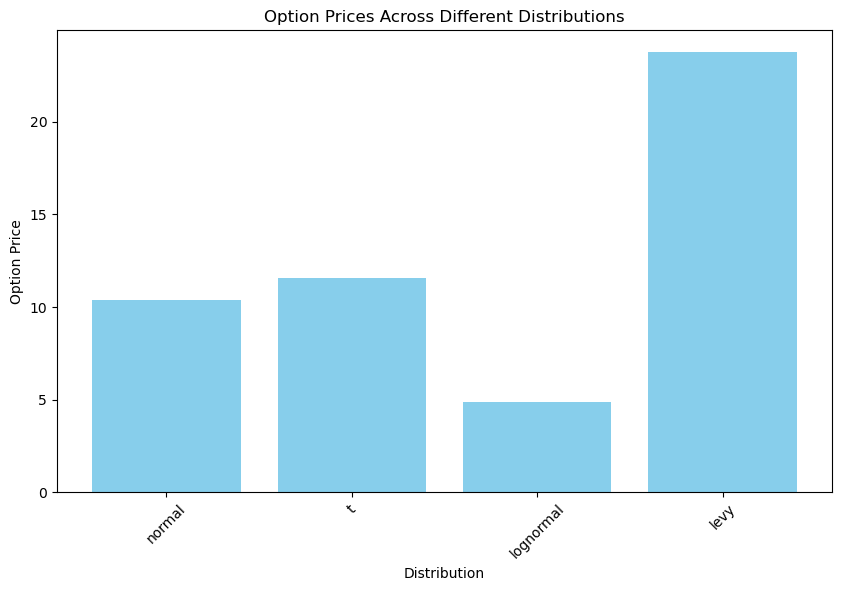

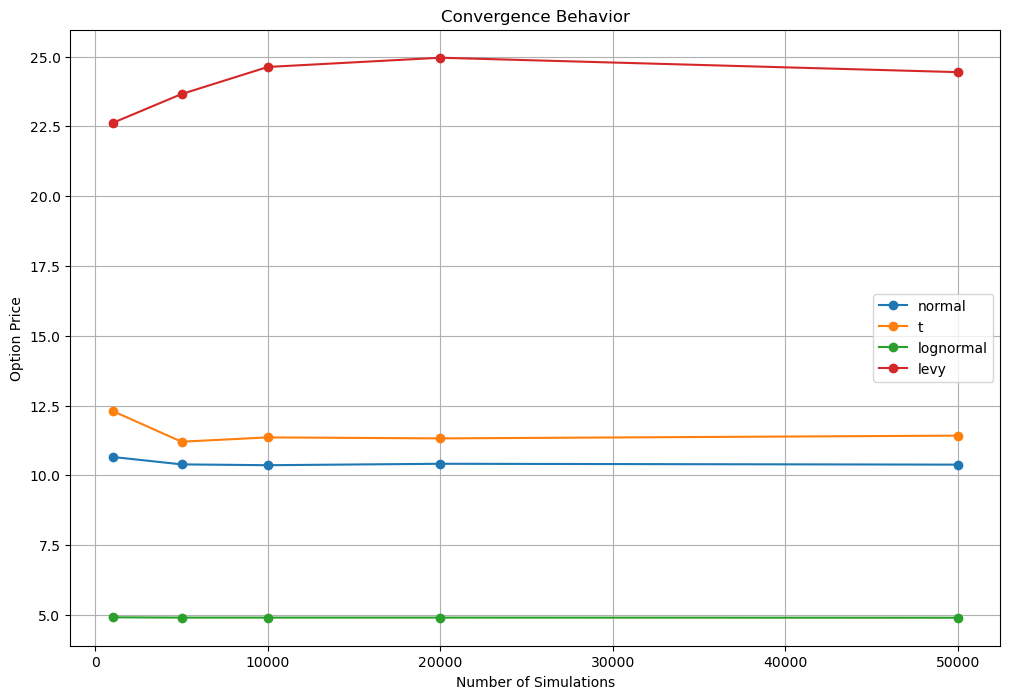

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, lognorm, levy_stable

np.random.seed(0)  # For reproducibility

# Function to simulate Monte Carlo paths remains the same as previously defined

# New function to visualize option prices across distributions
def plot_option_prices(distributions, prices):
    plt.figure(figsize=(10, 6))
    plt.bar(distributions, prices, color='skyblue')
    plt.xlabel('Distribution')
    plt.ylabel('Option Price')
    plt.title('Option Prices Across Different Distributions')
    plt.xticks(rotation=45)
    plt.show()

# New function to visualize convergence behavior
def plot_convergence_behavior(S, K, T, r, sigma, dist, num_simulations_list, **dist_params):
    prices = []
    for num_simulations in num_simulations_list:
        price = simulate_monte_carlo_paths(S, K, T, r, sigma, dist, num_simulations=num_simulations, **dist_params)
        prices.append(price)
    
    plt.plot(num_simulations_list, prices, label=dist, marker='o')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Option Price')
    plt.title('Convergence Behavior')

# Parameters setup
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
distributions = ['normal', 't', 'lognormal', 'levy']
dist_params = {'t': {'df': 10}, 'levy': {'alpha': 1.7}}  # Example params
num_simulations_list = [1000, 5000, 10000, 20000, 50000]
prices = []

# Calculate option prices for each distribution
for dist in distributions:
    price = simulate_monte_carlo_paths(S, K, T, r, sigma, dist, num_simulations=10000, **dist_params.get(dist, {}))
    prices.append(price)

plot_option_prices(distributions, prices)

# Plot convergence behavior for each distribution
plt.figure(figsize=(12, 8))
for dist in distributions:
    plot_convergence_behavior(S, K, T, r, sigma, dist, num_simulations_list, **dist_params.get(dist, {}))
plt.legend()
plt.grid(True)
plt.show()


## Future: Empirical Distribution for Monte Carlo

Future progress on this project will sample an empircal distribution rather than sampling from an analytical distribution which may not capture the true distribution of returns.